In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.special import psi, polygamma
from scipy import integrate

# plotting parameters
plt.rcParams["font.family"] = "serif"
plt.rcParams['lines.linewidth'] = 4.0
save_figures = True

# set random seed for reproducibility
np.random.seed(seed=1)

In [5]:
# Rate estimation theory model class constructor
class model_constructor:
    def __init__(self, nStim=2, n0=1, r0=0.1):
        self.n0 = n0                # prior stimulus duration
        self.r0 = r0                # prior number of reinforcements
        self.lambda_hat = np.zeros(nStim) + np.divide(r0,n0)   # initial rate estimates
        self.N = np.zeros(nStim) + n0 # initial stimulus durations
        
    def predict(self, x):
        # Predict reinforcement
        # x - event vector
        return np.dot(x,self.lambda_hat)
    
    def run(self, events, t_start, t_end, step_size = 0.5, eta = 0.7, limit = 2):
        # Run model over a time range. This function breaks the range into a series of small update steps.
        # events - function that takes time as input and returns an event vector (x) and reinforcement (r)
        # t_start - start time for integration
        # t_end - end time for integreation
        # step_size - length of time bin for integration
        # eta - learning rate parameter
        # limit - number of function evaluations per integration call
        steps = np.arange(t_start, t_end, step_size)
        update = lambda t: self.update(*events(t))      # update function to be integrated across time
        for i in range(len(steps)-1):
            self.N += step_size*eta     # update counts
            delta, _ = integrate.quad_vec(update, steps[i], steps[i+1], limit=limit, quadrature='gk15', epsabs=1e-05, epsrel=1e-05)
            self.lambda_hat += delta    # update rate estimates
            self.lambda_hat = np.fmax(0.00000001,self.lambda_hat)   # make sure rate estimates are greater than 0
    
    def update(self, x, r):
        # Update rate estimates
        # x - event vector
        # r - reinforcement
        return np.divide(x,self.N)*(r-self.predict(x))
    
# Events function generator for Pavlovian conditioning protocol with Poisson distributions or standard delay conditioning
def generate_events_function(ISI, ITI, lambda_vector=[]):
    total_trial_time = ISI + ITI

    def events(t):
        
        trial_time = t % total_trial_time
        
        if trial_time < ISI:
            # During stimulus presentation
            stimulus_present = [1]
        else:
            # During intertrial interval
            stimulus_present = [0]
        
        # Add the constant as the first component of the stimulus vector
        x = [1] + stimulus_present
        
        if lambda_vector == []: # delay conditioning
            if (ISI-0.1) < trial_time < ISI:    # allow a small (100ms) window of time for the reinforcement, to accommodate integration error
                reward = 1
            else:
                reward = 0
        else:   # Poisson generator
            # Compute the mean of the Poisson process
            mean_reward = np.dot(x, lambda_vector)
            
            # Sample the reward from the Poisson distribution
            reward = np.random.poisson(mean_reward)
        
        return x, reward

    return events

[0.52798397 1.41979799]


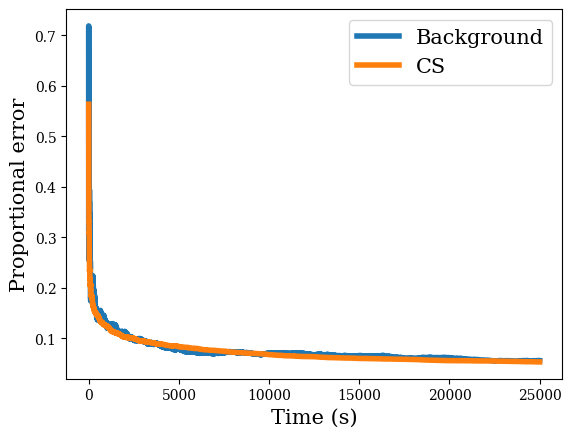

In [6]:
# Set up an events generator for a Pavlovian conditioning protocol with Poisson distributions
ISI = 2  # 2 seconds of stimulus
ITI = 5  # 5 seconds of intertrial interval
lambda_vector = [0.5, 1.5]  # Example lambda values
events_poisson = generate_events_function(ISI, ITI, lambda_vector)

# Generate learning curve (estimation error as a function of time)
model = model_constructor()
steps = np.arange(0, 25000, 1)
err = np.zeros((len(steps)-1,2))
for i in range(len(steps)-1):
    model.run(events_poisson, steps[i], steps[i+1])
    err[i,:] = model.lambda_hat - lambda_vector
    
# Print final estimate
print(model.lambda_hat)
    
# Plot results
plt.plot(np.divide(np.abs(err),lambda_vector))
plt.ylabel('Proportional error', fontsize=15)
plt.xlabel('Time (s)', fontsize=15)
plt.legend(['Background','CS'], fontsize=15)

if save_figures:
    plt.savefig("learning_curve_poisson.pdf", format="pdf", bbox_inches="tight")

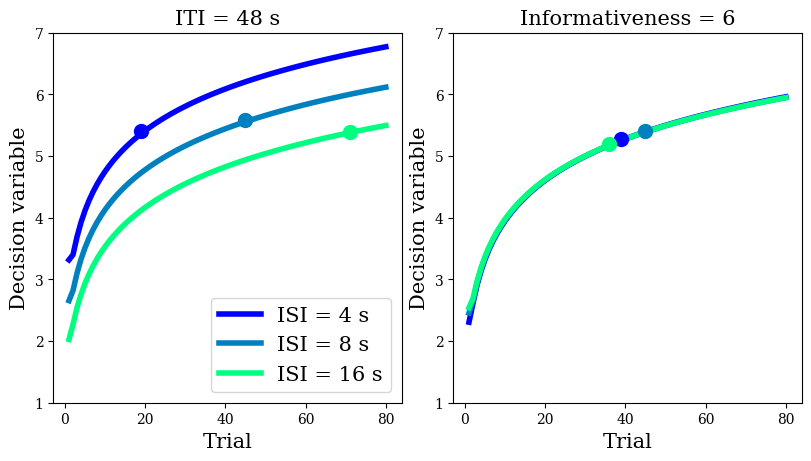

In [7]:
# Simulate decision variable over training

nTrials = 80
Inf = 6
ISI = [4, 8, 16]
conditions = ['ITI = 48 s', 'Informativeness = 6']

# data points from Gallistel & Gibbon (2000), Figure 11; data originally from Gibbon et al. (1977)
y = [[19, 45, 71], [39, 45, 36]]

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.winter(np.linspace(0,1,3)))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4.5), layout="constrained")

for k, condition in enumerate(conditions):
    p = np.zeros((nTrials,len(ISI)))
    for i in range(len(ISI)):
        
        if k == 0:
            ITI = 48
        elif k == 1:
            ITI = ISI[i]*(Inf - 1)
        
        C = ISI[i] + ITI
        events_delay = generate_events_function(ISI[i], ITI)
        model = model_constructor()
        for trial in range(nTrials):
            model.run(events_delay, trial*C, (trial+1)*C)
            p[trial,i] = np.log(model.lambda_hat[1] + model.lambda_hat[0]) - np.log(model.lambda_hat[0])
        
    axs[k].plot(np.arange(1,nTrials+1),p)
    for j, x in enumerate(y[k]):
        axs[k].plot(x,p[x,j],'o', color=colors[j], markersize=10)
    axs[k].set_ylabel('Decision variable', fontsize=15)
    axs[k].set_xlabel('Trial', fontsize=15)
    axs[k].set_ylim([1, 7])
    axs[k].set_title(condition, fontsize=15)
axs[0].legend(["ISI = " + str(x) + " s" for x in ISI], fontsize=15)

if save_figures:
    plt.savefig("decision_variable.pdf", format="pdf", bbox_inches="tight")

In [8]:
# Define acquisition speed functions

# function from Gallistel & Harris (2024), for example
def acq1(Inf, p):
    return np.log(p) - np.log(Inf-1)

# new function
def acq2(Inf, p):
    return np.log(p) - np.log(Inf)

In [9]:
# Calculate the Bayesian information criterion
def compute_BIC(p, x, y, fun):
    n = len(y)
    k = len(p)
    residuals = y - fun(x, *p)
    sse = np.sum(residuals**2)
    return n * np.log(sse / n) + k * np.log(n)

Posterior probability of model 2:  0.9999999909823868
Posterior probability of model 2:  0.9999999981233123
Posterior probability of model 2:  0.9999855602704526


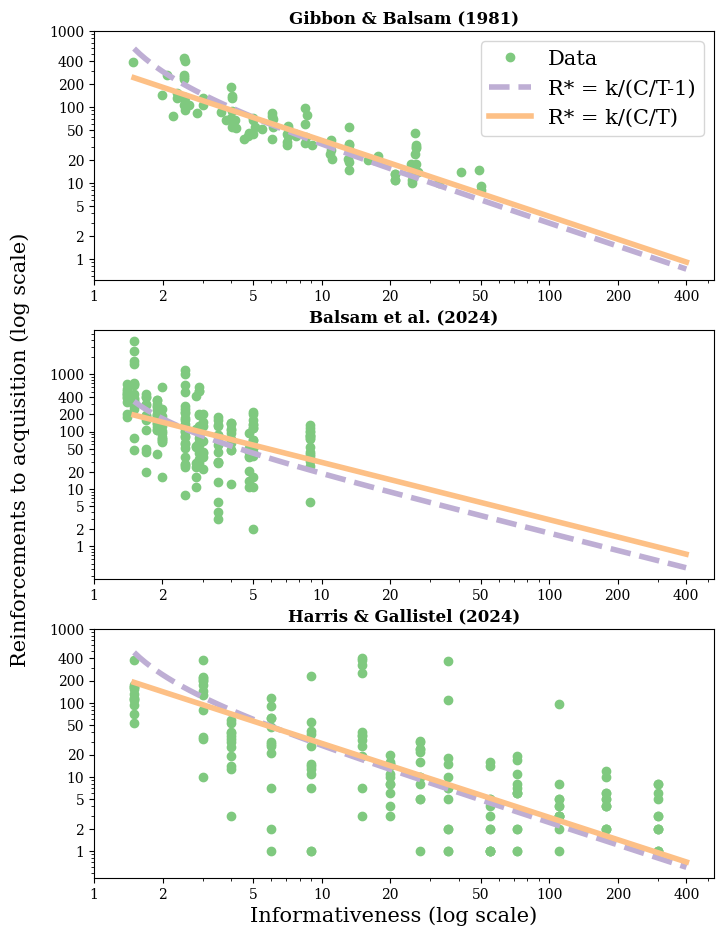

In [10]:
# Analyze acquisition speed as a function of informativeness

datasets = ["GibbonBalsam81.csv", "Balsam24.csv", "HarrisGallistel24.csv"]
name = ["Gibbon & Balsam (1981)", "Balsam et al. (2024)", "Harris & Gallistel (2024)"]

Inf = np.logspace(np.log10(1.5),np.log10(400),100)

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Accent.colors)
fig, axs = plt.subplots(ncols=1, nrows=len(datasets), figsize=(8, 11))

for i, dataset in enumerate(datasets):
    data = pd.read_csv(dataset)
    data = data.dropna()
    
    # plot data
    axs[i].loglog(data.Inf,data.R,'o')
    axs[i].set_title(name[i],weight='bold')
    
    # plot curve fits
    p, pcov = curve_fit(acq1, data.Inf, np.log(data.R))
    R = np.exp(acq1(Inf,p))
    axs[i].loglog(Inf,R,'--')
    
    p, pcov = curve_fit(acq2, data.Inf, np.log(data.R))
    R = np.exp(acq2(Inf,p))
    axs[i].loglog(Inf,R,'-')
    
    # model comparison
    BIC1 = compute_BIC(p, data.Inf, np.log(data.R), acq1)
    BIC2 = compute_BIC(p, data.Inf, np.log(data.R), acq2)
    BF = 0.5*(BIC1 - BIC2)      # log Bayes factor approximation
    prob2 = 1/(1+np.exp(-BF))   # approximation of the posterior under uniform prior
    print("Posterior probability of model 2: ",prob2)
    
    axs[i].set_xticks([1, 2, 5, 10, 20, 50, 100, 200, 400],[1, 2, 5, 10, 20, 50, 100, 200, 400])
    axs[i].set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 400, 1000],[1, 2, 5, 10, 20, 50, 100, 200, 400, 1000])
        
    
fig.text(0.5, 0.07, 'Informativeness (log scale)', ha='center', fontsize=15)
fig.text(0.02, 0.5, 'Reinforcements to acquisition (log scale)', va='center', rotation='vertical', fontsize=15)
axs[0].legend(['Data', 'R* = k/(C/T-1)','R* = k/(C/T)'], fontsize=15)

if save_figures:
    plt.savefig("curve_fits.pdf", format="pdf", bbox_inches="tight")

In [11]:
# Rescorla-Wagner simulator for delay conditioning
def rescorla_wagner(n_trials, ITI, ISI, binsize=1, lrate=np.array([0.1, 0.1]), degrade=False):

    C = ITI + ISI       # cycle time
    total_time = C * n_trials   # total protocol time
    times = np.arange(0, total_time + binsize, binsize)
    w = np.array([0.0, 0.0])
    trial = 0
    v = np.zeros(n_trials)
    W = np.zeros((n_trials,2))

    for time in times:
        trial_time = time % C

        if trial_time <= ISI:
            x = np.array([1, 1])
        else:
            x = np.array([1, 0])

        if trial_time == ISI:
            r = 1
            trial += 1
            v[trial - 1] = np.dot(w, x)
            W[trial-1,:] = w
        elif degrade==True and trial_time==ISI+binsize:
            r = 1       # single US during ITI in contingency degradation 
        else:
            r = 0

        w += lrate * x * (r - np.dot(w, x))

    return v, W

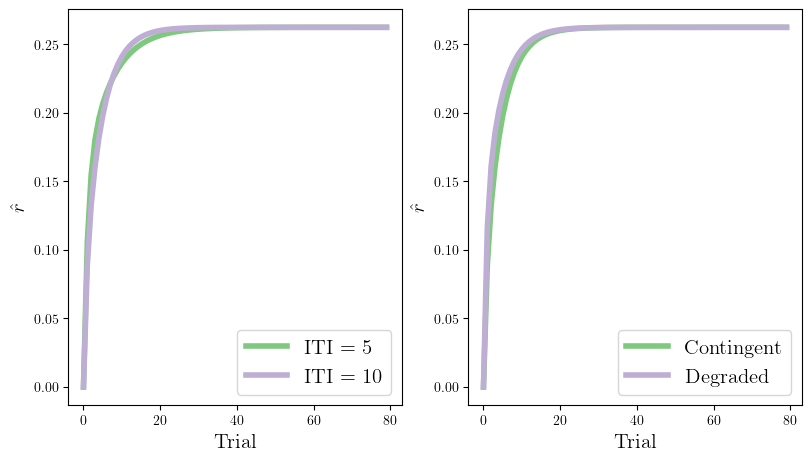

In [12]:
# Simulate the Rescorla-Wagner model

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Accent.colors)
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4.5), layout="constrained")

n_trials = 80

# ITI manipulation
ISI = 2
ITI = 5
v, W = rescorla_wagner(n_trials, ITI, ISI)
axs[0].plot(v)
ITI = 10
v, W = rescorla_wagner(n_trials, ITI, ISI)
axs[0].plot(v)
axs[0].set_ylabel('$\hat{r}$', fontsize=15)
axs[0].set_xlabel('Trial', fontsize=15)
axs[0].legend(['ITI = 5','ITI = 10'], fontsize=15)

# contingency degradation
v, W = rescorla_wagner(n_trials, ITI, ISI)
axs[1].plot(v)
v, W = rescorla_wagner(n_trials, ITI, ISI, degrade=True)
axs[1].plot(v)
axs[1].set_ylabel('$\hat{r}$', fontsize=15)
axs[1].set_xlabel('Trial', fontsize=15)
axs[1].legend(['Contingent','Degraded'], fontsize=15)

if save_figures:
    plt.savefig("learning_curve_RW.pdf", format="pdf", bbox_inches="tight")

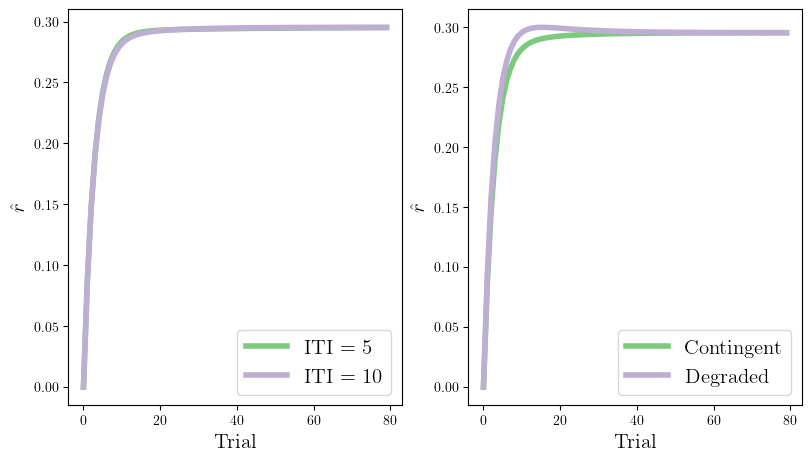

In [15]:
# Simulate the Rescorla-Wagner model with lower learning rate for context

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Accent.colors)
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4.5), layout="constrained")

n_trials = 80

# ITI manipulation
ISI = 2
ITI = 5
v, W = rescorla_wagner(n_trials, ITI, ISI, lrate=np.array([0.01, 0.1]))
axs[0].plot(v)
ITI = 10
v, W = rescorla_wagner(n_trials, ITI, ISI, lrate=np.array([0.01, 0.1]))
axs[0].plot(v)
axs[0].set_ylabel('$\hat{r}$', fontsize=15)
axs[0].set_xlabel('Trial', fontsize=15)
axs[0].legend(['ITI = 5','ITI = 10'], fontsize=15)

# contingency degradation
v, W = rescorla_wagner(n_trials, ITI, ISI, lrate=np.array([0.01, 0.1]))
axs[1].plot(v)
v, W = rescorla_wagner(n_trials, ITI, ISI, degrade=True, lrate=np.array([0.01, 0.1]))
axs[1].plot(v)
axs[1].set_ylabel('$\hat{r}$', fontsize=15)
axs[1].set_xlabel('Trial', fontsize=15)
axs[1].legend(['Contingent','Degraded'], fontsize=15)

if save_figures:
    plt.savefig("learning_curve_RW_2lrates.pdf", format="pdf", bbox_inches="tight")

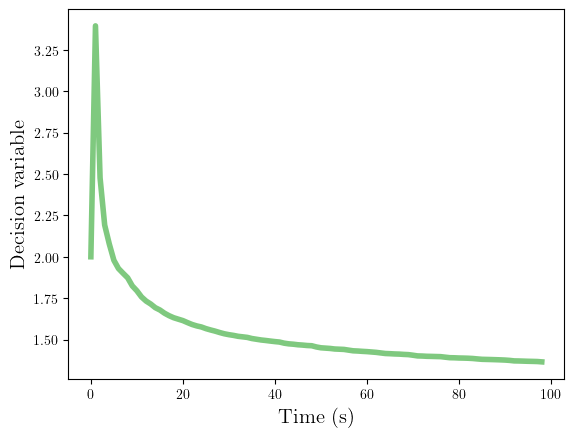

In [45]:
# Set up an events generator for a Pavlovian conditioning protocol with Poisson distributions
ISI = 2  # 2 seconds of stimulus
ITI = 5  # 5 seconds of intertrial interval
lambda_vector = [2, 0]  # lambda values
events_poisson = generate_events_function(ISI, ITI, lambda_vector)

# Generate learning curve (estimation error as a function of time)
reps = 10
steps = np.arange(0, 100, 1)
DV = np.zeros((len(steps)-1,reps))
for j in range(reps):
    model = model_constructor(r0=np.array([0.1, 0.1]), n0=np.array([1.0,0.01]))
    for i in range(len(steps)-1):
        model.run(events_poisson, steps[i], steps[i+1])
        DV[i,j] = np.sum(model.lambda_hat)/model.lambda_hat[0]
    
# Plot results
plt.plot(np.mean(DV,axis=1))
plt.ylabel('Decision variable', fontsize=15)
plt.xlabel('Time (s)', fontsize=15)

if save_figures:
    plt.savefig("decision_variable.pdf", format="pdf", bbox_inches="tight")